In [16]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation, FuncAnimation
from tqdm import tqdm

from datasets import CubeObstacle, CylinderObstacle
from utils.config import Hyperparameters as hparams
from utils.tools import calc_sig_strength

np.random.seed(52)
logging.basicConfig(level=logging.INFO)

In [17]:
# Create Obstacle

obstacle_ls = [
    CubeObstacle(-30, 15, 35, 60, 20),
    CubeObstacle(-30, -25, 45, 10, 35),
    CylinderObstacle(0, -30, 70, 10)
]


In [18]:
# Read datasets
df = pd.read_csv("data/data.csv")
df.head()

,gnd1_x,gnd1_y,gnd1_z,gnd2_x,gnd2_y,gnd2_z,gnd3_x,gnd3_y,gnd3_z,gnd4_x,gnd4_y,gnd4_z,result_x,result_y,result_z,sig1,sig2,sig3,sig4,sig_max
0,87.779510,-39.649590,0.0,-44.591267,-27.093930,0.0,25.873500,-24.152998,0.0,-42.690430,64.285030,0.0,14.0,-91.0,70.0,2.368590e+04,8.225893e+04,7.831066e+04,8.213270e+08,205377810.0
1,30.321653,-31.967329,0.0,58.952870,-34.662556,0.0,-57.061188,35.087585,0.0,-80.742070,97.990700,0.0,-10.0,-29.0,70.0,6.046116e+07,3.188759e+08,1.012846e+07,1.000910e+07,99868664.0
2,14.283162,87.894450,0.0,41.036907,-14.827680,0.0,-38.616985,3.109822,0.0,-18.899770,-94.655600,0.0,-83.0,18.0,70.0,6.055948e+04,2.332905e+09,1.196786e+05,4.418101e+04,583282370.0
3,91.820724,-38.144096,0.0,-97.767490,-87.535830,0.0,-38.923454,-82.563180,0.0,-50.140965,96.311630,0.0,21.0,-83.0,70.0,2.476373e+04,2.599646e+04,2.655345e+04,4.423216e+08,110599720.0
4,97.039070,-97.881325,0.0,-83.949066,52.897110,0.0,-65.369550,-96.192085,0.0,-76.816410,62.605904,0.0,13.0,-28.0,70.0,2.055547e+05,1.345178e+09,2.715464e+05,5.167884e+05,336543100.0


In [19]:
gnd_nodes = [df.iloc[0, :3].values, df.iloc[0, 3:6].values, df.iloc[0, 6:9].values, df.iloc[0, 9:12].values]
gnd_nodes = np.array(gnd_nodes, dtype=np.float32)
gnd_nodes

array([[ 87.77951 , -39.64959 ,   0.      ],
       [-44.591267, -27.09393 ,   0.      ],
       [ 25.8735  , -24.152998,   0.      ],
       [-42.69043 ,  64.28503 ,   0.      ]], dtype=float32)

INFO:root:Obstacle.points.shape: (3, 340)
INFO:root:Obstacle.points.shape: (3, 217)
INFO:root:Obstacle.points.shape: (3, 234)
INFO:root:gnd_nodes: [[ 87.77951  -39.64959    0.      ]
 [-44.591267 -27.09393    0.      ]
 [ 25.8735   -24.152998   0.      ]
 [-42.69043   64.28503    0.      ]]


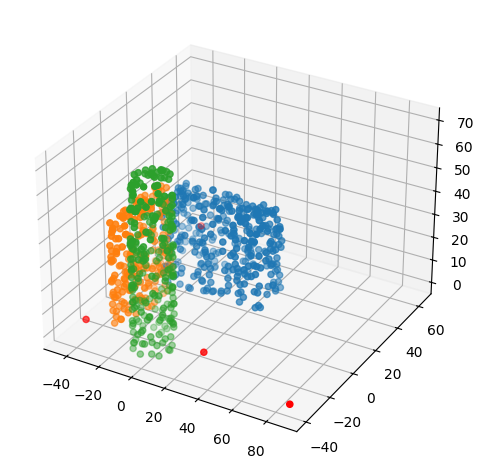

In [20]:
# environment visualization

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

gnd_nodes = np.array(gnd_nodes)
logging.info(f"gnd_nodes: {gnd_nodes}")
ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
fig.tight_layout()
plt.show()

In [21]:
# Brute Force coord

X, Y = np.meshgrid(
    np.arange(-hparams.area_size // 2, hparams.area_size // 2),
    np.arange(-hparams.area_size // 2, hparams.area_size // 2),
    indexing='xy'
)
Z = np.full_like(X, 70)

station_positions = np.stack((X, Y, Z), axis=-1).reshape(-1, 3)

In [22]:
sig = np.array([calc_sig_strength(station_pos, gnd_nodes, obstacle_ls) for station_pos in tqdm(station_positions)])
sig = sig.reshape(hparams.area_size, hparams.area_size)

max_idx = np.unravel_index(np.argmax(sig), sig.shape)
logging.info(f"Max Signal: {sig[max_idx]}, Index: {max_idx}")

100%|██████████| 40000/40000 [00:10<00:00, 3744.04it/s]
INFO:root:Max Signal: 10841.342332257784, Index: (np.int64(128), np.int64(67))


INFO:root:Obstacle.points.shape: (3, 340)
INFO:root:Obstacle.points.shape: (3, 217)
INFO:root:Obstacle.points.shape: (3, 234)


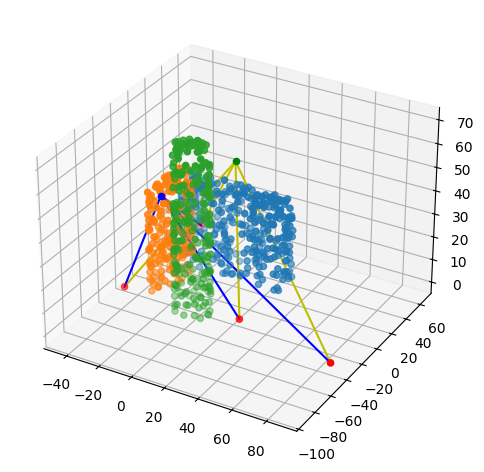

In [23]:
# Result Visualization

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")
    
ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter(max_idx[0]-(hparams.area_size//2), max_idx[1]-(hparams.area_size//2), 70, c='g')
ax.scatter(df.iloc[0, 12], df.iloc[0, 13], df.iloc[0, 14], c='b')
for gnd_node in gnd_nodes:
    ax.plot([gnd_node[0], max_idx[0]-(hparams.area_size//2)], [gnd_node[1], max_idx[1]-(hparams.area_size//2)], [gnd_node[2], 70], c='y')
    ax.plot([df.iloc[0, 12], gnd_node[0]], [df.iloc[0, 13], gnd_node[1]], [df.iloc[0, 14], gnd_node[2]], c='b')

fig.tight_layout()
plt.show()

INFO:root:Obstacle.points.shape: (3, 340)
INFO:root:Obstacle.points.shape: (3, 217)
INFO:root:Obstacle.points.shape: (3, 234)
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


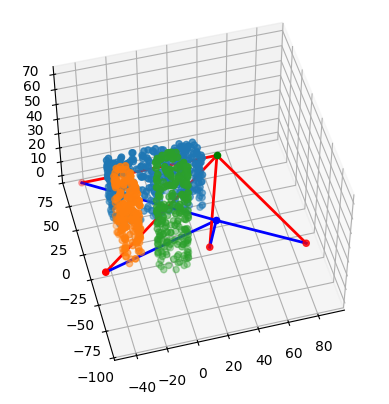

In [25]:
# save result as animation gif

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_proj_type('persp')
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter(max_idx[0] - (hparams.area_size // 2), max_idx[1] - (hparams.area_size // 2), 70, c='g')
ax.scatter(df.iloc[0, 12], df.iloc[0, 13], df.iloc[0, 14], c='b')
for gnd_node in gnd_nodes:
    ax.plot([gnd_node[0], max_idx[0] - (hparams.area_size // 2)], [gnd_node[1], max_idx[1] - (hparams.area_size // 2)],
            [gnd_node[2], 70], c='r', linewidth=2)
    ax.plot([df.iloc[0, 12], gnd_node[0]], [df.iloc[0, 13], gnd_node[1]], [df.iloc[0, 14], gnd_node[2]], c='b', linewidth=2)


def update(i):
    ax.view_init(elev=50, azim=255 + i)  # 시점의 높이를 높여 선이 더 잘 보이도록 설정


anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=100)

anim.save("./results/dataset_test/anim.gif", writer='imagemagick')


INFO:root:Obstacle.points.shape: (3, 340)
INFO:root:Obstacle.points.shape: (3, 217)
INFO:root:Obstacle.points.shape: (3, 234)


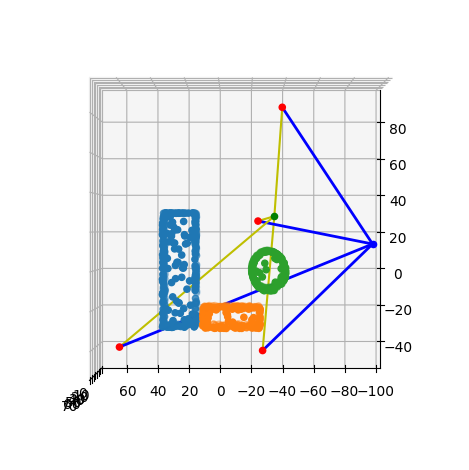

In [27]:
# Save the top view as image

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=180)
for obstacle in obstacle_ls:
    obstacle.plot(ax)
    logging.info(f"Obstacle.points.shape: {obstacle.points.shape}")

ax.scatter(gnd_nodes[:, 0], gnd_nodes[:, 1], gnd_nodes[:, 2], c='r')
ax.scatter(max_idx[0] - (hparams.area_size // 2), max_idx[1] - (hparams.area_size // 2), 70, c='g')
ax.scatter(df.iloc[0, 12], df.iloc[0, 13], df.iloc[0, 14], c='b')
for gnd_node in gnd_nodes:
    ax.plot([gnd_node[0], max_idx[0] - (hparams.area_size // 2)], [gnd_node[1], max_idx[1] - (hparams.area_size // 2)],
            [gnd_node[2], 70], c='y')
    ax.plot([df.iloc[0, 12], gnd_node[0]], [df.iloc[0, 13], gnd_node[1]], [df.iloc[0, 14], gnd_node[2]], c='b', linewidth=2)

fig.tight_layout()
plt.savefig("./results/dataset_test/top.png")
plt.show()